# Medical Image Classification

**Company Use Case:**


**Approach:**



The following Notebook will show two approaches to do this with ConcreteML.

**Dataset Information:**

_Dataset  1:_

<span style="color:yellow">description</span>

**Dataset Source:**

https://medmnist.com/

Dataset 1:

https://github.com/logpai/loghub/blob/master/Android/Android_2k.log_structured.csv

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# MedMNIST
import medmnist

# SciKit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

# PyTorch
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models import resnet50, vgg16
from torchsummary import summary

# Load Data

In [2]:
dataset = 'PneumoniaMNIST'

In [3]:
DataClass = getattr(medmnist, dataset)

# Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[.5], std=[.5])
])

# download data
train_dataset = DataClass(split='train', transform=transform, download=True)
eval_dataset = DataClass(split='val', transform=transform, download=True)
test_dataset = DataClass(split='test', transform=transform, download=True)
print('\n', train_dataset)

# dataloader
train_loader = data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
eval_loader = data.DataLoader(dataset=eval_dataset, batch_size=32, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

Using downloaded and verified file: /home/lukas/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/lukas/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/lukas/.medmnist/pneumoniamnist.npz

 Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /home/lukas/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0


In [4]:
# train_dataloader to numpy/tensor array
xtrain_np = np.concatenate([batch[0].numpy() for batch in train_loader], axis=0)
ytrain_np = np.concatenate([batch[1].numpy() for batch in train_loader], axis=0)

# eval_dataloader to numpy/tensor array
xval_np = np.concatenate([batch[0].numpy() for batch in eval_loader], axis=0)
yval_np = np.concatenate([batch[1].numpy() for batch in eval_loader], axis=0)

# test_dataloader to numpy/tensor array
xtest_np = np.concatenate([batch[0].numpy() for batch in test_loader], axis=0)
ytest_np = np.concatenate([batch[1].numpy() for batch in test_loader], axis=0)

print('Numpy Data\n')
print(f'Samples:\t{xtrain_np.shape[0]}')
print(f'Channels:\t{xtrain_np.shape[1]}')
print(f'Height:\t\t{xtrain_np.shape[2]}')
print(f'Width:\t\t{xtrain_np.shape[3]}')

Numpy Data

Samples:	4708
Channels:	1
Height:		28
Width:		28


In [5]:
# ResNet50 Feature Extraction

def feature_extractor(X, model='resnet50'):
    # duplicate channels to 3
    data = np.repeat(X, 3, axis=1)
    # convert to tensor
    data = torch.tensor(data, dtype=torch.float)

    if model == 'resnet50':
        # load pretrained ResNet50
        model = resnet50()
    elif model == 'vgg16':
        # load pretrained VGG16
        model = vgg16()
    # remove last layer
    model = torch.nn.Sequential(*(list(model.children())[:-1]))
    # add flatten layer
    model.add_module('flatten', torch.nn.Flatten())
    # set model to eval mode
    model.eval()
    # extract features
    with torch.no_grad():
        features = model(data).detach().numpy()
    # to pandas dataframe
    dataframe = pd.DataFrame(features)

    return dataframe

In [6]:
xtrain_res = feature_extractor(xtrain_np)
xval_res = feature_extractor(xval_np)
xtest_res = feature_extractor(xtest_np)

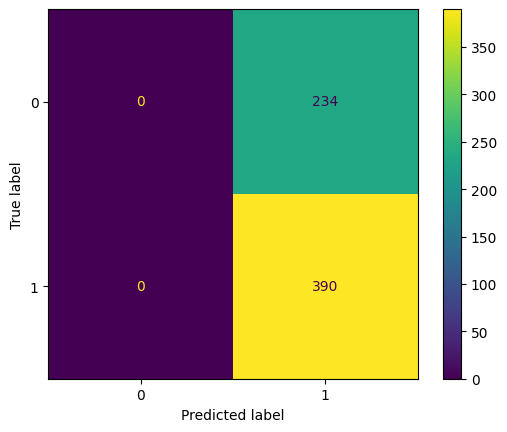

In [7]:
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier().fit(xtrain_res, ytrain_np)
y_pred = xgb.predict(xtest_res)

ConfusionMatrixDisplay(confusion_matrix(ytest_np, y_pred)).plot()

In [8]:
test = feature_extractor(xtrain_res[[3]])

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [4708, 3]

In [ ]:
# xtrain_tab = feature_extractor(xtrain_res)
xval_tab = feature_extractor(xval_res)
# xtest_tab = feature_extractor(xtest_res)

In [ ]:
# # display three sample from each class
# fig, ax = plt.subplots(2, 3, figsize=(10, 5))

# # get one sample from each class
# normal, pneumonia = [], []
# for images, labels in train_loader:
#     while len(normal) < 3 or len(pneumonia) < 3:
#         for i in range(len(labels)):
#             if labels[i] == 0 and len(normal) < 3:
#                 normal.append(images[i])
#             elif labels[i] == 1 and len(pneumonia) < 3:
#                 pneumonia.append(images[i])

# # display images
# for i in range(3):
#     ax[0, i].imshow(normal[i].squeeze(), cmap='gray')
#     ax[0, i].set_title('Normal')
#     ax[0, i].axis('off')
#     ax[1, i].imshow(pneumonia[i].squeeze(), cmap='gray')
#     ax[1, i].set_title('Pneumonia')
#     ax[1, i].axis('off')

In [ ]:
# train_dataloader to numpy/tensor array
train_images, train_labels = [], []

for batch in train_loader:
    images, labels = batch
    train_images.append(images.numpy())
    train_labels.append(labels.numpy())

xtrain_np, ytrain_np = np.concatenate(train_images, axis=0), np.concatenate(train_labels, axis=0)
xtrain_tensor, ytrain_tensor = torch.FloatTensor(xtrain_np), torch.FloatTensor(ytrain_np)

# eval_dataloader to numpy/tensor array
eval_images, eval_labels = [], []

for batch in eval_loader:
    images, labels = batch
    eval_images.append(images.numpy())
    eval_labels.append(labels.numpy())

xval_np, yval_np = np.concatenate(eval_images, axis=0), np.concatenate(eval_labels, axis=0)
xval_tensor, yval_tensor = torch.FloatTensor(xval_np), torch.FloatTensor(yval_np)

# test_dataloader to numpy/tensor array
test_images, test_labels = [], []

for batch in test_loader:
    images, labels = batch
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

xtest_np, ytest_np = np.concatenate(test_images, axis=0), np.concatenate(test_labels, axis=0)
xtest_tensor, ytest_tensor = torch.FloatTensor(xtest_np), torch.FloatTensor(ytest_np)

In [ ]:
print(f'Samples:\t{xtrain_np.shape[0]}')
print(f'Channels:\t{xtrain_np.shape[1]}')
print(f'Height:\t\t{xtrain_np.shape[2]}')
print(f'Width:\t\t{xtrain_np.shape[3]}')

In [ ]:
model = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
      torch.nn.ReLU(),
      torch.nn.AvgPool2d(kernel_size=2, stride=2),
      torch.nn.Flatten(),
      torch.nn.Linear(in_features=169, out_features=1, bias=True),
      torch.nn.Sigmoid()
)

summary(model, input_size=(1, 28, 28))

In [ ]:
epochs = 40
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in tqdm(range(epochs)):
  # training
  model.train()
  for i in range(0, len(xtrain_tensor), 1):
    inputs = xtrain_tensor[i:i+1]
    labels = ytrain_tensor[i:i+1]

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # log metrics
  model.eval()
  with torch.no_grad():
    train_outputs = model(xtrain_tensor)
    train_loss = criterion(train_outputs, ytrain_tensor)
    predicted = torch.round(train_outputs)
    train_accuracy = accuracy_score(predicted.detach().numpy(), ytrain_tensor.detach().numpy())*100

    val_outputs = model(xval_tensor)
    val_loss = criterion(val_outputs, yval_tensor)
    predicted = torch.round(val_outputs)
    val_accuracy = accuracy_score(predicted.detach().numpy(), yval_tensor.detach().numpy())*100

  train_losses.append(train_loss.item())
  val_losses.append(val_loss.item())
  train_accuracies.append(train_accuracy)
  val_accuracies.append(val_accuracy)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='Training Loss')
ax[0].plot(val_losses, label='Validation Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(train_accuracies, label='Training Accuracy')
ax[1].plot(val_accuracies, label='Validation Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

In [ ]:
# evaluate
with torch.no_grad():
  correct = 0
  total = 0
  for i in range(0, len(xtest_tensor), 1):
    inputs = xtest_tensor[i:i+1]
    labels = ytest_tensor[i:i+1]

    outputs = model(inputs)
    predicted = torch.round(outputs)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print(f'Accuracy: {100 * correct / total:.2f}%')